In [1]:
%load_ext autoreload
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
import numpy as np
from tqdm.auto import tqdm



2024-11-19 11:17:43.382393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 11:17:43.464759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731986263.498748   15063 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731986263.508875   15063 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 11:17:43.584846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
!ls ../data/raw/ielts

ielts_writing_dataset.csv


In [3]:
fp = '../data/raw/ielts/ielts_writing_dataset.csv'
df = pd.read_csv(fp)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Checking what the BERT Embeddings actually are

### 1.2 Tokenizing 

In [5]:
text = df.sample(random_state = 12).Essay.values[0]
print(text)

As we are living into a monetary society, it's unavoidable for people to discuss about money matters in daily conversation about housing mortgage, salaries and other living expenses. The financial anxiety has become a main source of headache that lingers on especially for the young generation who has to bear the increasing burden of a city life. From a standpoint of a college student, I believe it's not a postive development that should have occurred in our modern society.
When our conversation turns to money issues, it doesn's really help up with our status quo, but only further exacerbates social anxiety by unnecessay comparison and higher expectation. I personally have similar experiences when friends start to talk about their monthly pocket money and daily luxuries they prefer. We are widely variated in family background, social classes and opportunities. If our daily social discourses are always filled with monetary issues, it is only widening the social gaps between different gro

In [6]:
texts_list =  text.split('\n')
texts_list[0]

"As we are living into a monetary society, it's unavoidable for people to discuss about money matters in daily conversation about housing mortgage, salaries and other living expenses. The financial anxiety has become a main source of headache that lingers on especially for the young generation who has to bear the increasing burden of a city life. From a standpoint of a college student, I believe it's not a postive development that should have occurred in our modern society."

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
tokenizer.__dict__.keys()

dict_keys(['init_inputs', 'init_kwargs', 'name_or_path', '_processor_class', 'model_max_length', 'padding_side', 'truncation_side', 'model_input_names', 'clean_up_tokenization_spaces', 'deprecation_warnings', '_in_target_context_manager', '_bos_token', '_eos_token', '_unk_token', '_sep_token', '_pad_token', '_cls_token', '_mask_token', '_pad_token_type_id', '_additional_special_tokens', 'verbose', 'added_tokens_encoder', 'added_tokens_decoder', 'unique_no_split_tokens', 'tokens_trie', '_decode_use_source_tokenizer', 'vocab', 'ids_to_tokens', 'do_basic_tokenize', 'basic_tokenizer', 'wordpiece_tokenizer'])

In [9]:
tokenized_texts = [tokenizer(paragraph, padding="max_length", truncation=True, return_tensors="pt") for paragraph in texts_list]

In [10]:
len(tokenized_texts)
tokenized_texts[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [11]:
# The first 10 token idxes
tokenized_texts[0]['input_ids'][0][:10]

tensor([  101,  2004,  2057,  2024,  2542,  2046,  1037, 12194,  2554,  1010])

In [12]:
token_ids = tokenized_texts[0]['input_ids'][0].tolist() 
first_text_tokens = tokenizer.convert_ids_to_tokens(token_ids)

In [13]:
# It seems like BERT's tokens are mostly word-level tokens
print(first_text_tokens[:100])

['[CLS]', 'as', 'we', 'are', 'living', 'into', 'a', 'monetary', 'society', ',', 'it', "'", 's', 'una', '##vo', '##ida', '##ble', 'for', 'people', 'to', 'discuss', 'about', 'money', 'matters', 'in', 'daily', 'conversation', 'about', 'housing', 'mortgage', ',', 'salaries', 'and', 'other', 'living', 'expenses', '.', 'the', 'financial', 'anxiety', 'has', 'become', 'a', 'main', 'source', 'of', 'headache', 'that', 'linger', '##s', 'on', 'especially', 'for', 'the', 'young', 'generation', 'who', 'has', 'to', 'bear', 'the', 'increasing', 'burden', 'of', 'a', 'city', 'life', '.', 'from', 'a', 'stand', '##point', 'of', 'a', 'college', 'student', ',', 'i', 'believe', 'it', "'", 's', 'not', 'a', 'post', '##ive', 'development', 'that', 'should', 'have', 'occurred', 'in', 'our', 'modern', 'society', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


In [14]:
print(texts_list[0].split()[:100])

['As', 'we', 'are', 'living', 'into', 'a', 'monetary', 'society,', "it's", 'unavoidable', 'for', 'people', 'to', 'discuss', 'about', 'money', 'matters', 'in', 'daily', 'conversation', 'about', 'housing', 'mortgage,', 'salaries', 'and', 'other', 'living', 'expenses.', 'The', 'financial', 'anxiety', 'has', 'become', 'a', 'main', 'source', 'of', 'headache', 'that', 'lingers', 'on', 'especially', 'for', 'the', 'young', 'generation', 'who', 'has', 'to', 'bear', 'the', 'increasing', 'burden', 'of', 'a', 'city', 'life.', 'From', 'a', 'standpoint', 'of', 'a', 'college', 'student,', 'I', 'believe', "it's", 'not', 'a', 'postive', 'development', 'that', 'should', 'have', 'occurred', 'in', 'our', 'modern', 'society.']


### 1.2 Getting the Embeddings 

In [15]:
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
model.__dict__.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'config', 'name_or_path', 'warnings_issued', 'generation_config', '_is_hf_initialized', 'is_loaded_in_4bit', 'is_loaded_in_8bit', 'is_quantized'])

In [17]:
# len(list(model.named_parameters())) # length of 199

In [18]:
layers_to_freeze = ['0', '1', '2'] # select the initial layers so we don't finetune those
for idx, (name, param) in enumerate(model.named_parameters()):
    
    layer_num = (name.split('.'))[2]  
    if idx%10==0:
        print(name, len(param))
        print(layer_num)
    # if layer_num in layers_to_freeze 
    #     param.requires_grad = False
    # else:  # Unfreeze layers 2 and beyond
    #     param.requires_grad = True

embeddings.word_embeddings.weight 30522
weight
encoder.layer.0.attention.self.value.bias 768
0
encoder.layer.0.output.LayerNorm.bias 768
0
encoder.layer.1.attention.output.LayerNorm.bias 768
1
encoder.layer.2.attention.self.key.bias 768
2
encoder.layer.2.output.dense.bias 768
2
encoder.layer.3.attention.output.dense.bias 768
3
encoder.layer.4.attention.self.query.bias 768
4
encoder.layer.4.intermediate.dense.bias 3072
4
encoder.layer.5.attention.self.value.bias 768
5
encoder.layer.5.output.LayerNorm.bias 768
5
encoder.layer.6.attention.output.LayerNorm.bias 768
6
encoder.layer.7.attention.self.key.bias 768
7
encoder.layer.7.output.dense.bias 768
7
encoder.layer.8.attention.output.dense.bias 768
8
encoder.layer.9.attention.self.query.bias 768
9
encoder.layer.9.intermediate.dense.bias 3072
9
encoder.layer.10.attention.self.value.bias 768
10
encoder.layer.10.output.LayerNorm.bias 768
10
encoder.layer.11.attention.output.LayerNorm.bias 768
11


In [19]:
tokenized_texts[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [20]:
with torch.no_grad():
    outputs = [model(**tokenized_text) for tokenized_text in tokenized_texts] ## Need to unpack the dictionary 

In [21]:
# last hidden state correspond to the semantic meaning for each input token
outputs[0].keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [22]:
outputs[0].last_hidden_state.shape # last couple outputs should be the same as they correspeond to the padding 

torch.Size([1, 512, 768])

In [23]:
outputs[0].last_hidden_state[:,-1,:10]

tensor([[ 0.2756, -0.1254,  0.5092,  0.0574, -0.1748,  0.0659,  0.0663,  0.0585,
          0.1448, -0.5244]])

In [24]:
# they are still different
outputs[0].last_hidden_state[:,-2,:10]

tensor([[ 0.5500,  0.0455,  0.3594,  0.1329, -0.1600, -0.0850, -0.0554,  0.3473,
          0.2738, -0.2329]])

In [25]:
outputs[0].pooler_output.shape

torch.Size([1, 768])

In [26]:
torch.mean(outputs[0].last_hidden_state[:,:,:], axis=1).shape

torch.Size([1, 768])

In [27]:
# mean_tensor = torch.mean(outputs[0].last_hidden_state[:,:,:], axis=1).squeeze()
# mean_tensor .shape, mean_tensor[:10]

In [28]:
# pooled_output = outputs[0].pooler_output.squeeze()
# pooled_output .shape, pooled_output[:10]

In [29]:
# np.dot(pooled_output, mean_tensor) / (np.linalg.norm(pooled_output)*np.linalg.norm(mean_tensor))

In [30]:
df.head(1)

,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",NaN,NaN,NaN,NaN,NaN,5.5


##  2. Get the embeddings


In [31]:
import sys
sys.path.append('../src')
from features.chunking_preprocessing import Chunker
# %load_ext autoreload
%reload_ext autoreload

[nltk_data] Downloading package punkt to /home/ginger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
chunker = Chunker(data=df, data_set_name='IELTS')

In [33]:
chunker.get_chunks()

,Original_Index,Data_Source,Question,Paragraph,Rating,Number_Of_Words
0,0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",5.5,125
1,1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,6.5,104
2,1,2,Rich countries often give money to poorer coun...,"Once unprivilged countries find their niche, t...",6.5,123
3,1,2,Rich countries often give money to poorer coun...,"In summary, types of aid varies from country t...",6.5,31
4,2,1,The bar chart below describes some changes abo...,The left chart shows the population change hap...,5.0,72
...,...,...,...,...,...,...
5985,1433,2,Universities should allocate the same amount o...,"Yes, I do feel that universities should have a...",5.0,118
5986,1433,2,Universities should allocate the same amount o...,Also it will attract other students sports and...,5.0,45
5987,1434,2,Modern medicine helps to live a longer life. D...,The modern medicine is very important for livi...,5.0,118
5988,1434,2,Modern medicine helps to live a longer life. D...,But old people are very important in human soc...,5.0,123


In [34]:
min_words_idx = chunker.chunked_df['Number_Of_Words'].argmin()
chunker.chunked_df.iloc[min_words_idx,3]

"This city's number of houses is unpredictable every year."

In [35]:
max_words_idx = chunker.chunked_df['Number_Of_Words'].argmax()
chunker.chunked_df.iloc[max_words_idx,:]

Original_Index                                                   249
Data_Source                                                        2
Question           Write about the following topic.Some people fe...
Paragraph          there is no deying the fact the main requireme...
Rating                                                           3.0
Number_Of_Words                                                  278
Name: 1063, dtype: object

In [90]:
chunker.chunked_df['Number_Of_Words'].max()

278

In [39]:
chunker.chunked_df.sort_values(by='Number_Of_Words', ascending=False)

,Original_Index,Data_Source,Question,Paragraph,Rating,Number_Of_Words
1063,249,2,Write about the following topic.Some people fe...,there is no deying the fact the main requireme...,3.0,278
4119,967,2,Write about the following topic.Buying things ...,"Firstly, the advanteges of online shopping is ...",5.0,166
1062,248,1,The bar chart below describes some changes abo...,this above bar chart it is depicts the percent...,3.5,160
3645,863,2,Traffic and housing problems could be solved b...,Traffic and housing problems has been a major ...,6.5,146
5297,1243,2,People living in large cities have to face man...,What are the difficulties while living in larg...,7.0,137
...,...,...,...,...,...,...
4867,1142,1,"The bar chart shows the scores of teams A, B a...",This chart depicts three team's score from 200...,4.0,10
590,140,1,The diagram below shows the life cycle of the ...,Overall，the life of the honey bee is shot and ...,5.5,10
2724,641,2,Individuals can do nothing to improve the envi...,In essay will prove my point with reasons and ...,7.0,10
4749,1114,1,The climograph below shows average monthly tem...,The chart illustrates the monthly temperatures...,7.0,10


In [37]:
df.iloc[249,2]

'there is no deying the fact the main requirement of goods it is debatable these days , which some people think the goods it is duty of supermarket , while others believe that responsibility of customers and really we have take a strict way for this issue , in this essay will dicuss both of side and will draw my personal experience , in one hand talking the group of people which but the refer guilty for supermarket and industry , when the products setting in the shop they empleoy of supermarket the must packaing off the goods after that they but them in store , so that why some think tha because it is this esay way when we dealing this proplomitc instaed we aviod , on the other hand it is another story here which the concept it is the custromer halt cunsume buy numres of pack for illustrated the must bring while shopping pack and do not taking from store in , addition even if we forgeat when we geting outdoor try reimend your self prior you go , hence the belife that is very essentail 

In [45]:
df[df.Overall==1.0].Essay.values

array(["For centuries, artworks have been titled  'Work of Art' based on their extraordinary qualities. However, some people argue that nowadays, the standards are decreasing and the labelling of substandard artworks as 'masterpieces' has become ubiquitous. The upcoming essay will discuss why I agree that original paintings are being neglected while usual ones are being praised.\nFirstly, the superficial nature of humans is responsible for this change. These days, people do not see the meaning behind the painting or the message the artist is trying to convey rather they buy those paintings which are popular and contemporary. To illustrate it further, in art auctions it can be seen that when one person bids on one painting, no matter whether it is good or bad, others also start putting their money on it. Thus it is clear that normal art forms are winning prizes due to public attention.\nSecondly, some artists might bribe the organizers of exhibitions to promote their canvas. Indeed, the

In [ ]:
# min word count of 1
# 6.5    1012
# 6.0     990
# 7.0     985
# 5.5     732
# 7.5     572
# 5.0     422
# 8.0     335
# 8.5     143
# 4.5      84
# 9.0      60
# 4.0      45
# 3.5      20
# 3.0      14
# 1.0       4
# Name: Rating, dtype: int64

## 3. Embedding

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
from features.get_bert_embeddings import BertFeatureExtractor


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
extractor = BertFeatureExtractor()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 3.1 Class EMbeddings

In [86]:
class_embeddings = extractor.transform(chunker.chunked_df, embedding_type='[CLS]')

  0%|          | 0/5990 [00:00<?, ?it/s]

In [89]:
# class_embeddings

In [93]:
X = np.vstack(class_embeddings)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [95]:
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Score Category'] = chunker.chunked_df['Rating']

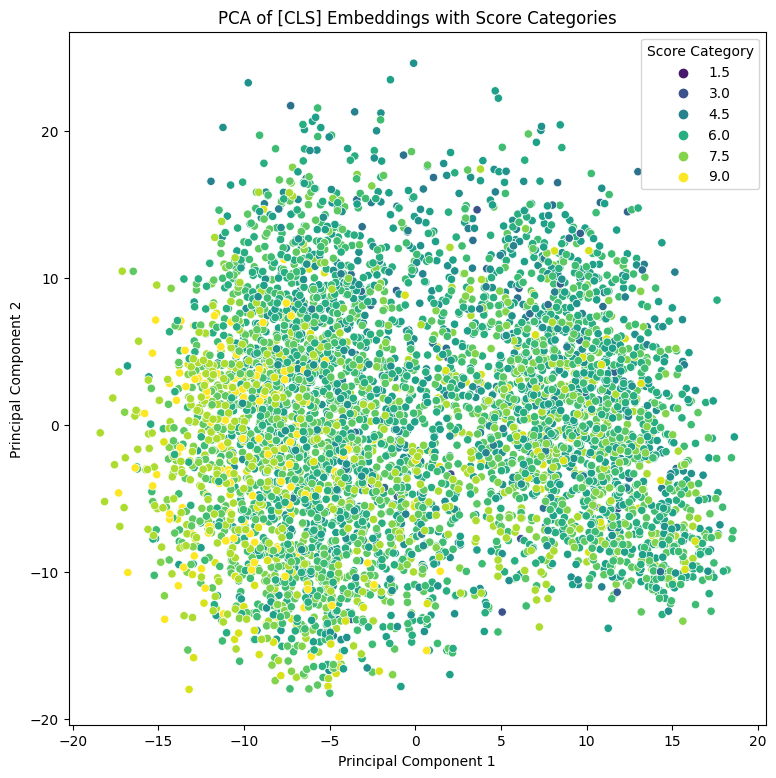

In [120]:
plt.figure(figsize=(9,9))
sns.scatterplot(x='PC1', y='PC2', hue='Score Category', data=pca_df, palette='viridis');
# Add plot title and labels
plt.title('PCA of [CLS] Embeddings with Score Categories')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()

## 3.2 Mean Embeddings

In [101]:
mean_embeddings = extractor.transform(chunker.chunked_df, embedding_type='mean')

  0%|          | 0/5990 [00:00<?, ?it/s]

In [113]:
# Convert the list of mean embeddings into a NumPy array
X_mean_embeddings = np.vstack(mean_embeddings)

# Standardize the data before performing PCA
scaler = StandardScaler()
X_scaled_mean_embeddings = scaler.fit_transform(X_mean_embeddings)

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca_mean_embeddings = pca.fit_transform(X_scaled_mean_embeddings)

# Convert PCA result into a DataFrame for easy plotting
pca_mean_embeddings_df = pd.DataFrame(data=X_pca_mean_embeddings, columns=['PC1', 'PC2'])

# Add the 'Score Category' (Rating) from the original DataFrame
pca_mean_embeddings_df['Score Category'] = chunker.chunked_df['Rating']


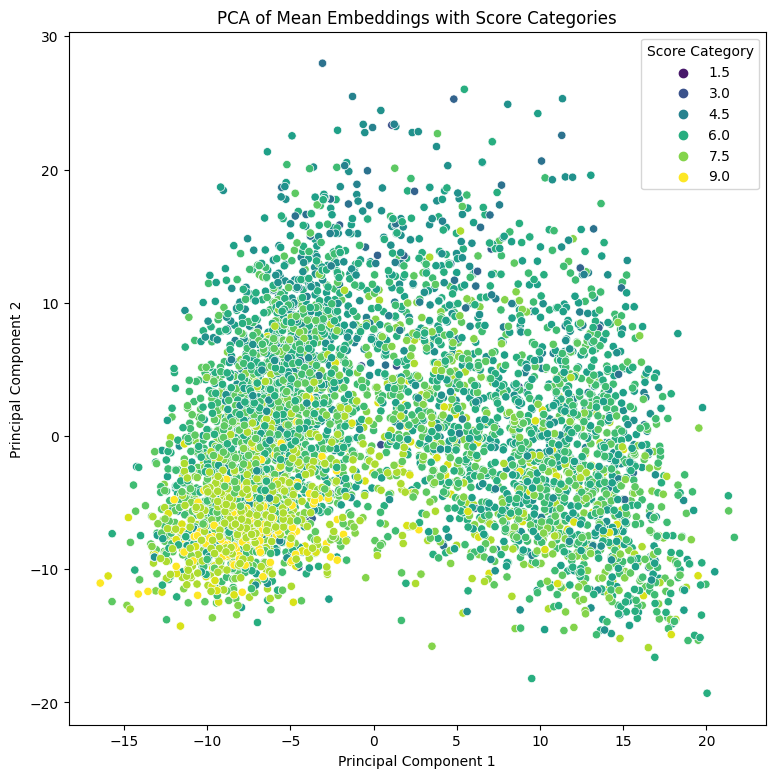

In [119]:
# Create a scatterplot of the first two principal components, colored by the score category
plt.figure(figsize=(9, 9))
sns.scatterplot(x='PC1', y='PC2', hue='Score Category', data=pca_mean_embeddings_df, palette='viridis')

# Add plot title and labels
plt.title('PCA of Mean Embeddings with Score Categories')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()


## 3.3 Output Embeddings

In [111]:
output_embeddings = extractor.transform(chunker.chunked_df)

  0%|          | 0/5990 [00:00<?, ?it/s]

In [116]:

X_output_embeddings = np.vstack(output_embeddings)

# Standardize the data before performing PCA
scaler = StandardScaler()
X_scaled_output_embeddings = scaler.fit_transform(X_output_embeddings)

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca_output_embeddings = pca.fit_transform(X_scaled_output_embeddings)

# Convert PCA result into a DataFrame for easy plotting
pca_output_embeddings_df = pd.DataFrame(data=X_pca_output_embeddings, columns=['PC1', 'PC2'])

# Add the 'Score Category' (Rating) from the original DataFrame
pca_output_embeddings_df['Score Category'] = chunker.chunked_df['Rating']



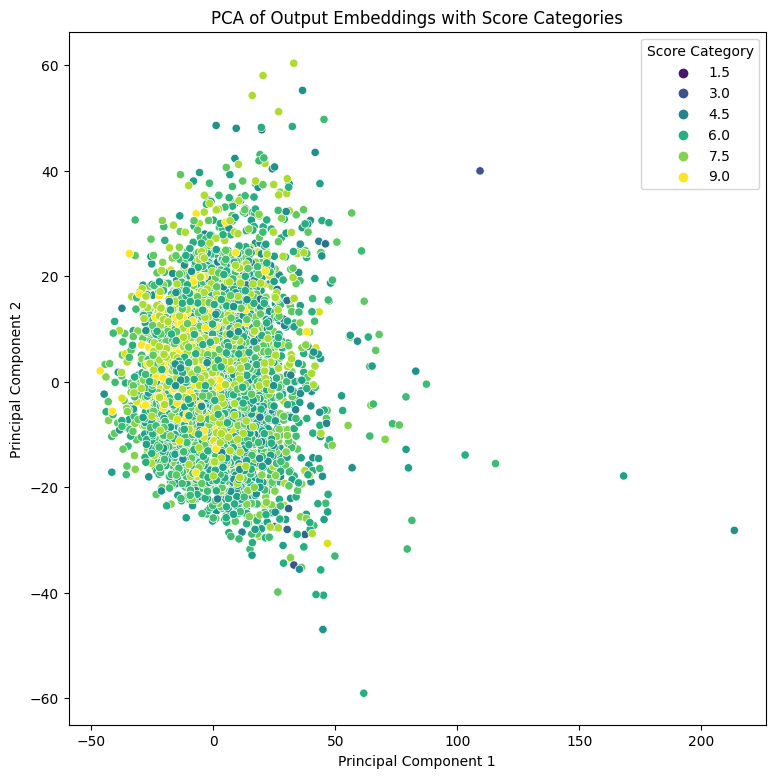

In [118]:
# Create a scatterplot of the first two principal components, colored by the score category
plt.figure(figsize=(9, 9))
sns.scatterplot(x='PC1', y='PC2', hue='Score Category', data=pca_output_embeddings_df, palette='viridis')

# Add plot title and labels
plt.title('PCA of Output Embeddings with Score Categories')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()